# Part 0: Load in libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact
import localcider
from localcider.sequenceParameters import SequenceParameters



# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDRs

## 1.1 - Load in all IDR information

In [3]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in all IDR z-score data

In [4]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

90
(24508, 90)


## 1.3 - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length - used when don't care about cluster distance

In [5]:
minidrlength=50
minidrlinkerlength=70

subidrsdfNODIST=humandf[humandf['IDR Length']>=minidrlength]
subidrsdfNODIST=subidrsdfNODIST[ (subidrsdfNODIST['IDR Length']>=minidrlinkerlength) | (subidrsdfNODIST['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
print(subidrsdfNODIST.isnull().any())
subidrsdfNODIST = subidrsdfNODIST.fillna('')
print(subidrsdfNODIST)

subaccsNODIST=subidrsdfNODIST['Uniprot'].tolist()
subaccswnumsNODIST=subidrsdfNODIST['Uniprot w IDRnum'].tolist()
subgeneswnumsNODIST=subidrsdfNODIST['Gene'].tolist()
subclustersNODIST=subidrsdfNODIST['Cluster Number'].tolist()
subseqlensNODIST=subidrsdfNODIST['IDR Length'].tolist()
substposNODIST=subidrsdfNODIST['Start Pos'].tolist()
subenposNODIST=subidrsdfNODIST['End Pos'].tolist()
subproteinlengthNODIST=subidrsdfNODIST['Full Protein Length'].tolist()
submininterclustdistNODIST=subidrsdfNODIST['Min Inter Clust Dist'].tolist()
subterminiNODIST=subidrsdfNODIST['IDR Position'].tolist()
subseqsNODIST=subidrsdfNODIST['Sequence'].tolist()
sublocstringNODIST=subidrsdfNODIST['HPA Location'].tolist()


sublocationbyunistringNODIST=sublocstringNODIST

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6ZSZ5_4   ARHGEF1

## 1.4 - Get number of X in all subset sequences

In [6]:
myaas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

aanumlistall=[[] for _ in range(len(myaas))]
for s in range(0,len(fullseqs)):
    #print(s)
    currseq=fullseqs[s]
    SeqOb=SequenceParameters(currseq)
    aafrac=SeqOb.get_amino_acid_fractions()
    slen=SeqOb.get_length()
    
    for a in range(0,len(myaas)):
        aanumlistall[a].append(aafrac[myaas[a]]*slen)
        
print(np.shape(aanumlistall))

(20, 24508)


## 1.5 - Get cumulative patch length for each subsequence sequence

In [19]:
numInt=2 # Number of allowable interruption residues
minBlockLen=4 # Must have at least minBlockLen lysines in the block

testaas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

xrichlen=[[] for _ in range(len(testaas))]

for s in range(0,len(fullseqs)):
    currseq=fullseqs[s]
    
    ## Fraction of sequence containing patches
    counta=-1
    for a in testaas:
        counta=counta+1
        justKs='0'*len(currseq) # Set string of zeros

        pos=[i for i, ltr in enumerate(currseq) if ltr == a] # Find positions of the residue of interest

        # If interruption length is less than or equal to numInt then say these positions are also the residue of interest
        pos2=pos
        for p in range(0,len(pos)-1):
            tdi=pos[p+1]-pos[p]
            if tdi > 1 and tdi<=numInt+1:
                myt=list(range(pos[p]+1,pos[p+1]))
                for item in myt:
                    pos2.append(item)


        # For positions make those 1 in string of zeros   
        justKs = list(justKs)
        for p in pos2:
            justKs[p]='1'
        justKs = ''.join(justKs)


        the_ones = re.findall(r"1+", justKs) # Find all consecutive 1s
        idx_ones=[[m.start(0), m.end(0)] for m in re.finditer(r"1+", justKs)] # Find indices of ones

        numpatches=0
        count=-1
        patchescombined=''
        for o in the_ones:
            count=count+1
            myrange=idx_ones[count] # Get indices for each consecutive strength
            subseq=currseq[myrange[0]:myrange[1]] # Get subseq that corresponds to this stength
            pos3=[i for i, ltr in enumerate(subseq) if ltr == a] # Get positions of the actual residue of interest in this subseq
            # If the number of the actual residue of interest is greater than or equal to minBlockLen add to the number of patches and string patches together in string
            if len(pos3)>=minBlockLen:
                numpatches=numpatches+1
                patchescombined+=subseq

        xrichlen[counta].append(len(patchescombined))
        
print(len(xrichlen))

20


## 1.6 - Add new data to dataframe

In [20]:
dfrich=pd.DataFrame()
dfrich['Gene']=fullgeneswnums
dfrich['Cluster']=fullclusternum
dfrich['Location']=fulllocationbyunistring
dfrich['Uniprot']=fullaccs
dfrich['Uniprot w Num']=fullaccswnums
dfrich['IDR Length']=fullseqlens

for a in range(0,len(myaas)):
    dfrich['Num '+myaas[a]]=aanumlistall[a]
    
for a in range(0,len(myaas)):
     dfrich['Cumulative Patch '+myaas[a]]=xrichlen[a]

mysubfeat=['Frac M','Frac Q','Q Patch']
## Add in z-score data ##
for f in range(0,len(mysubfeat)):
    fidx=myfeat.index(mysubfeat[f])
    print(f)
    tmplist=[]
    for s in range(0,len(fullaccswnums)):
        idx=fullaccswnums.index(fullaccswnums[s])
        tmplist.append(fullzvec[idx,fidx])
    dfrich[mysubfeat[f]]=tmplist

print(dfrich)

0
1
2
                 Gene  Cluster                  Location Uniprot  \
0      KRTAP4-16 IDR1       27                            G5E9R7   
1          TULP4 IDR1       17                            Q9NRJ4   
2          TULP4 IDR2        1                            Q9NRJ4   
3          TULP4 IDR3       27                            Q9NRJ4   
4          TULP4 IDR4       27                            Q9NRJ4   
...               ...      ...                       ...     ...   
24503     YTHDF3 IDR2       11                            Q7Z739   
24504     LONRF1 IDR1       29  Cytosol, Plasma membrane  Q17RB8   
24505     LONRF1 IDR2       24  Cytosol, Plasma membrane  Q17RB8   
24506      CDC73 IDR1       17               Nucleoplasm  Q6P1J9   
24507      CDC73 IDR2       17               Nucleoplasm  Q6P1J9   

      Uniprot w Num  IDR Length  Num A  Num C  Num D  Num E  ...  \
0          G5E9R7_1          53    0.0    0.0    0.0    0.0  ...   
1          Q9NRJ4_1          50    4.0   

## 1.7 - Load in nucleoplasm complex information with transcription factors

In [42]:
dfcompclust=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='Nucleoplasm_w_Factors_Binding')

dfcompclust=dfcompclust.sort_values(by=['General Process'])
print(dfcompclust)

ccgeneralprocess=dfcompclust['General Process'].tolist()
cccategory=dfcompclust['Category'].tolist()
ccgene=dfcompclust['Gene'].tolist()
ccacc=dfcompclust['Accession'].tolist()

ccgeneralprocess = [x if x != 'Splicing factors' else 'Other splicing factors1' for x in ccgeneralprocess]
ccgeneralprocess = [x if x != 'ASAP complex' else 'ASAP complex1' for x in ccgeneralprocess]
cccategory = [x if x != 'CREBBP/EP301' else 'CREBBP/EP300' for x in cccategory]

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

print(uniccgeneralprocess)
print(unicccategory)
print(len(unicccategory))

     Accession     Gene               General Process              Category  \
130     O14647     CHD2  Chromatin remodeling complex         CHD complexes   
85      Q9ULG1    INO80  Chromatin remodeling complex                 INO80   
84      Q15532     SS18  Chromatin remodeling complex         ncBAF complex   
83      Q6STE5  SMARCD3  Chromatin remodeling complex         ncBAF complex   
82      Q92925  SMARCD2  Chromatin remodeling complex         ncBAF complex   
...        ...      ...                           ...                   ...   
1267    O95096   NKX2-2          Transcription factor  Transcription factor   
1266    P43699   NKX2-1          Transcription factor  Transcription factor   
1265    Q9UD57   NKX1-2          Transcription factor  Transcription factor   
1263    O15226     NKRF          Transcription factor  Transcription factor   
1252    Q16649    NFIL3          Transcription factor  Transcription factor   

                         Location  Cluster Number T

## 1.8 - Sort data by feature of interest

In [30]:
curraa='Q'
#sortbyval='Num '+curraa
sortbyval='Cumulative Patch '+curraa
topnum=30 #80

dfrichsorted = dfrich.sort_values(by=[sortbyval], ascending=False)
print(dfrichsorted.head(topnum))

topidrsval=dfrichsorted[sortbyval].tolist()[:topnum]
topidrsgene=dfrichsorted['Gene'].tolist()[:topnum]
topidrsuni=dfrichsorted['Uniprot'].tolist()[:topnum]
topidrslen=dfrichsorted['IDR Length'].tolist()[:topnum]

print(dfrichsorted[['Gene',sortbyval]].head(topnum))

pos=[i for i, x in enumerate(cccategory) if x=='COMPASS-like complexes']

for p in pos:
    curracc=ccacc[p]
    if curracc in topidrsuni:
        myidx=topidrsuni.index(curracc)
        print(topidrsgene[myidx]+': '+str(myidx+1))

               Gene  Cluster                   Location Uniprot Uniprot w Num  \
990     KMT2D IDR10       11                    Cytosol  O14686     O14686_10   
18994   PAXIP1 IDR2       11      Nucleoplasm, Vesicles  Q6ZW49      Q6ZW49_2   
15643   ZNF853 IDR1       11                   Nucleoli  P0CG23      P0CG23_1   
13072     TOX3 IDR2       10                Nucleoplasm  O15405      O15405_2   
17558    MED12 IDR8       11                Nucleoplasm  Q93074      Q93074_8   
23238    MED15 IDR2       11                Nucleoplasm  Q96RN5      Q96RN5_2   
7852     ATXN8 IDR1       11                             Q156A1      Q156A1_1   
10429   TCERG1 IDR2       15                Nucleoplasm  O14776      O14776_2   
17132   TRERF1 IDR3       11                Nucleoplasm  Q96PN7      Q96PN7_3   
8684     NCOA6 IDR1       11                Nucleoplasm  Q14686      Q14686_1   
19450    MAML2 IDR5       11             Nuclear bodies  Q8IZL2      Q8IZL2_5   
8281      CIZ1 IDR3       11

## 1.9 - Plot sorted IDRs by grammar feature for all IDRs

(-1.0, 3.0)

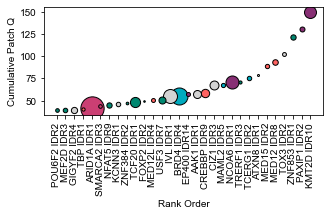

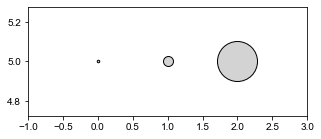

In [31]:
#mygeneralcolors={'RNA binding':'#276026', 'Enhanceosomes':'#3d2663', 'Chromatin remodeling complex':'#872f74', 'Histone modifying complex':'#cb3f73', 'RNA polymerase II-mediated transcription':'#ff6361'}
mygeneralcolors={'RNA binding':'#276026','Transcription factor':'#008770','Transcription co-factor':'#00aabe','Enhanceosomes':'#3d2663', 'Chromatin remodeling complex':'#cb3f73', 'Histone modifying complex':'#872f74', 'RNA polymerase II-mediated transcription':'#ff6361'}

plt.figure(figsize=(5,2))

tmp = np.argsort(topidrslen)
sort_index2 = tmp[::-1] 

for s in sort_index2:
    if topidrsuni[s] in ccacc:
        myidx=ccacc.index(topidrsuni[s])
        mycurrcolor=mygeneralcolors[ccgeneralprocess[myidx]]
        plt.plot(topnum-s+1,topidrsval[s],'o',markersize=(topidrslen[s])/40,markerfacecolor=mycurrcolor,markeredgecolor='black')
    else:
        plt.plot(topnum-s+1,topidrsval[s],'o',markersize=(topidrslen[s])/40,markerfacecolor='lightgrey',markeredgecolor='black')
    
plt.xticks(np.arange(len(topidrsgene)+1,1,-1),topidrsgene,rotation=90)

plt.ylabel(sortbyval)
plt.xlabel('Rank Order')

#plt.savefig('Figures/2024_02/top_idrs_sorted_all_locations/All_sapien_IDRs_feature_'+sortbyval+'_w_process_reversed.pdf', transparent=True, bbox_inches = "tight") 

plt.figure(figsize=(5,2))
lencir=[100,400,1600]
for s in range(0,len(lencir)):
    plt.plot(s,5,'o',markersize=(lencir[s])/40,markerfacecolor='lightgrey',markeredgecolor='black')
plt.xlim([-1,s+1])
#plt.savefig('Figures/2024_02/IDR_length_legend_100_400_1600.pdf', transparent=True, bbox_inches = "tight") 


## 1.10 - Save data to excel file

In [44]:
sortbyval=['Num M','Cumulative Patch Q','Num Y']
topnum=80 #30 for plotting, 80 for visualization

accsbyproc=[[] for _ in range(len(uniccgeneralprocess))]
for s in range(0,len(uniccgeneralprocess)):
    #print(mysorteduniccgeneralprocess[s])
    pos=[i for i, x in enumerate(ccgeneralprocess) if x==uniccgeneralprocess[s]]
    for p in pos:
        accsbyproc[s].append(ccacc[p])

topgenesbytype=[[] for _ in range(len(sortbyval))]
topunibytype=[[] for _ in range(len(sortbyval))]
for v in range(0,len(sortbyval)):
    print(sortbyval[v])
    dfrichsorted = dfrich.sort_values(by=sortbyval[v], ascending=False)


    topidrsval=dfrichsorted[sortbyval[v]].tolist()[:topnum]
    topidrsgene=dfrichsorted['Gene'].tolist()[:topnum]
    topidrsuni=dfrichsorted['Uniprot'].tolist()[:topnum]
    topidrslen=dfrichsorted['IDR Length'].tolist()[:topnum]
    
    topidrproc=[]
    for i in range(0,len(topidrsuni)):
        whichproc=[]
        for s in range(0,len(uniccgeneralprocess)):
            if topidrsuni[i] in accsbyproc[s]:
                whichproc.append(uniccgeneralprocess[s])
                
        if len(whichproc)==1:
            topidrproc.append(whichproc[0])
        elif len(whichproc)>1:
            topidrproc.append(', '.join(whichproc))
        else:
            topidrproc.append('')
    

    topidrsdf=pd.DataFrame()
    topidrsdf['Uniprot']=topidrsuni
    topidrsdf['Gene']=topidrsgene
    topidrsdf['IDR Length']=topidrslen
    topidrsdf[sortbyval[v]]=topidrsval
    topidrsdf['Process']=topidrproc
    print(topidrsdf.head(30))

    #with pd.ExcelWriter('../Supplementary_Tables/Table_S5.xlsx', engine='openpyxl',mode='a') as writer:
    #    topidrsdf.to_excel(writer,sheet_name='top_'+str(topnum)+'_'+sortbyval[v])


Num M
   Uniprot            Gene  IDR Length  Num M  \
0   Q86UU0      BCL9L IDR5         482   37.0   
1   Q14686      NCOA6 IDR1         522   35.0   
2   O14497     ARID1A IDR1         932   34.0   
3   Q8NFD5     ARID1B IDR4         464   34.0   
4   Q8NFD5     ARID1B IDR2         511   33.0   
5   Q15532       SS18 IDR1         348   30.0   
6   O14497     ARID1A IDR3         539   30.0   
7   H0YM25  GOLGA6L22 IDR3         399   30.0   
8   O43670     ZNF207 IDR1         397   29.0   
9   Q9C0J8      WDR33 IDR1         774   27.0   
10  Q9UKN1      MUC12 IDR2        4647   26.0   
11  Q09472     EP300 IDR11         322   24.0   
12  Q9BWW4      SSBP3 IDR1         292   23.0   
13  Q15637        SF1 IDR3         316   23.0   
14  Q92793     CREBBP IDR9         334   22.0   
15  P81877      SSBP2 IDR1         238   22.0   
16  Q02930      CREB5 IDR1         308   22.0   
17  Q92793     CREBBP IDR6         366   20.0   
18  P09234      SNRPC IDR1         109   20.0   
19  Q8N9W4   G

## 1.11 - Load in nucleoplasm complex information without transcription factors

In [45]:
dfcompclust=pd.read_excel('data/Nucleoplasm_processes_w_clusters_IDRs_gte_70_and_nonlinkers_gte_50.xlsx')

dfcompclust=dfcompclust.sort_values(by=['General Process'])
print(dfcompclust)

ccgeneralprocess=dfcompclust['General Process'].tolist()
cccategory=dfcompclust['Category'].tolist()
ccgene=dfcompclust['Gene'].tolist()
ccacc=dfcompclust['Accession'].tolist()

ccgeneralprocess = [x if x != 'Splicing factors' else 'Other splicing factors1' for x in ccgeneralprocess]
ccgeneralprocess = [x if x != 'ASAP complex' else 'ASAP complex1' for x in ccgeneralprocess]
cccategory = [x if x != 'CREBBP/EP301' else 'CREBBP/EP300' for x in cccategory]

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

print(uniccgeneralprocess)
print(unicccategory)
print(len(unicccategory))

     Unnamed: 0 Accession     Gene                           General Process  \
0             0    P24863     CCNC  RNA polymerase II-mediated transcription   
1             1    P49336     CDK8  RNA polymerase II-mediated transcription   
2             2    Q9BWU1    CDK19  RNA polymerase II-mediated transcription   
3             3    Q15648     MED1  RNA polymerase II-mediated transcription   
4             4    Q9NX70    MED29  RNA polymerase II-mediated transcription   
..          ...       ...      ...                                       ...   
482         482    O15042   U2SURP                               RNA binding   
483         483    Q8TBF4    ZCRB1                               RNA binding   
484         484    Q14966   ZNF638                               RNA binding   
485         485    Q15695  ZRSR2P1                               RNA binding   
486         486    Q15696    ZRSR2                               RNA binding   

                               Category

## 1.12 - Get number in top 80 for each process

In [36]:
sortbyval=['Num M','Cumulative Patch Q','Num Y']
#sortbyval=['R Patch','pos-neg']
topnum=80 #30 for plotting, 80 for visualization

topgenesbytype=[[] for _ in range(len(sortbyval))]
topunibytype=[[] for _ in range(len(sortbyval))]
for v in range(0,len(sortbyval)):
    print(sortbyval[v])
    dfrichsorted = dfrich.sort_values(by=sortbyval[v], ascending=False)


    topidrsval=dfrichsorted[sortbyval[v]].tolist()[:topnum]
    topidrsgene=dfrichsorted['Gene'].tolist()[:topnum]
    topidrsuni=dfrichsorted['Uniprot'].tolist()[:topnum]
    topidrslen=dfrichsorted['IDR Length'].tolist()[:topnum]
    
    #print(dfrichsorted[['Gene',sortbyval[v]]].head(topnum))
    
    for i in range(0,len(topidrsgene)):
        topgenesbytype[v].append(topidrsgene[i])
        topunibytype[v].append(topidrsuni[i])

    #pos=[i for i, x in enumerate(cccategory) if x=='COMPASS-like complexes']
    #pos=[i for i, x in enumerate(cccategory) if x=='Mediator complex']
    pos=[i for i, x in enumerate(cccategory) if x=='BAF complex']

    for p in pos:
        curracc=ccacc[p]
        if curracc in topidrsuni:
            myidx=topidrsuni.index(curracc)
            print(topidrsgene[myidx]+': '+str(myidx+1))
            
print(len(topgenesbytype[0]))

Num M
SS18 IDR1: 6
SMARCA4 IDR1: 40
ARID1B IDR4: 4
ARID1A IDR1: 3
SMARCC1 IDR3: 79
Cumulative Patch Q
SMARCA2 IDR3: 25
ARID1B IDR1: 75
ARID1A IDR1: 26
Num Y
SS18L1 IDR2: 11
SS18 IDR1: 9
ARID1B IDR4: 22
ARID1A IDR1: 5
80


## 1.13 - Plot number of top 80 IDRs in transcriptional complexes

Mediator complex
33
Num M
MED1 IDR6: 43
Cumulative Patch Q
MED12 IDR8: 5
Cumulative Patch Q
MED12L IDR4: 19
Cumulative Patch Q
MED15 IDR2: 6
[ 1.  3.  0. 29.]
33.0=33
PIC
29
Cumulative Patch Q
TBP IDR1: 27
Cumulative Patch Q
GTF2A1 IDR1: 71
[ 0.  2.  0. 27.]
29.0=29
CREBBP/EP300
2
Num M
CREBBP IDR9: 15
Cumulative Patch Q
CREBBP IDR9: 13
Num M
EP300 IDR11: 12
Cumulative Patch Q
EP300 IDR11: 32
[1. 1. 0. 0.]
2.0=2
RNA Polymerase II subunits
12
Num Y
POLR2A IDR1: 3
[ 0.  0.  1. 11.]
12.0=12
Super elongation complex
17
[ 0.  0.  0. 17.]
17.0=17
SAGA complex
17
[ 0.  0.  0. 17.]
17.0=17
BAF complex
22
Num Y
SS18L1 IDR2: 11
Num M
SS18 IDR1: 6
Num Y
SS18 IDR1: 9
Num M
SMARCA4 IDR1: 40
Cumulative Patch Q
SMARCA2 IDR3: 25
Num M
ARID1B IDR4: 4
Cumulative Patch Q
ARID1B IDR1: 75
Num Y
ARID1B IDR4: 22
Num M
ARID1A IDR1: 3
Cumulative Patch Q
ARID1A IDR1: 26
Num Y
ARID1A IDR1: 5
Num M
SMARCC1 IDR3: 79
[ 5.  1.  1. 15.]
22.0=22
ncBAF complex
15
Num M
SMARCA4 IDR1: 40
Num Y
SS18L1 IDR2: 11
Num M
SS18 

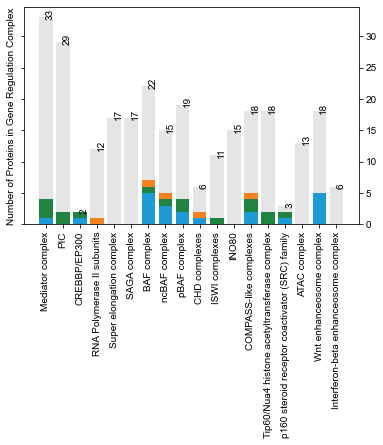

In [40]:
## Right now this looks at each protein as one so if had two idrs that each had a top feature would only pick the top IDR
#mysorteduniccgeneralprocess=['CHD complexes', 'INO80', 'ncBAF complex', 'pBAF complex', 'ISWI complexes', 'BAF complex', 'Wnt enhanceosome complex', 'Interferon-beta enhanceosome complex', 'COMPASS-like complexes', 'Tip60/Nua4 histone acetyltransferase complex', 'p160 steroid receptor coactivator (SRC) family', 'ATAC complex', 'Mediator complex', 'SAGA complex', 'PIC', 'CREBBP/EP300', 'RNA Polymerase II subunits', 'Super elongation complex']
#mysorteduniccgeneralprocess=unicccategory
mysorteduniccgeneralprocess=['Mediator complex', 'PIC', 'CREBBP/EP300', 'RNA Polymerase II subunits', 'Super elongation complex', 'SAGA complex', 'BAF complex', 'ncBAF complex', 'pBAF complex', 'CHD complexes', 'ISWI complexes', 'INO80', 'COMPASS-like complexes', 'Tip60/Nua4 histone acetyltransferase complex', 'p160 steroid receptor coactivator (SRC) family', 'ATAC complex', 'Wnt enhanceosome complex', 'Interferon-beta enhanceosome complex']


f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')

count0=[]
count1=[]
count2=[]
count3=[]
for s in range(0,len(mysorteduniccgeneralprocess)):
    count=np.zeros((len(sortbyval)+1))
    print(mysorteduniccgeneralprocess[s])
    pos=[i for i, x in enumerate(cccategory) if x==mysorteduniccgeneralprocess[s]]
    print(len(pos))

    for p in pos:
        curracc=ccacc[p]
        tmpidx=[100, 100, 100]
        for v in range(0,len(sortbyval)):
            if curracc in topunibytype[v]:
                tmpidx[v]=topunibytype[v].index(curracc)
                print(sortbyval[v])
                print(topgenesbytype[v][tmpidx[v]]+': '+str(tmpidx[v]+1))
        minidx=tmpidx.index(min(tmpidx))
        if tmpidx[minidx]==100:
            count[len(sortbyval)]=count[len(sortbyval)]+1
        else:
            count[minidx]=count[minidx]+1

    print(count)
    count0.append(count[0])
    count1.append(count[1])
    count2.append(count[2])
    count3.append(count[3])
    print(str(sum(count))+'='+str(len(pos)))
    #count=count/sum(count)
    
    plt.bar(s, count[0], color='#1d9bd7')
    plt.bar(s, count[1], bottom=count[0], color='#218342')
    plt.bar(s, count[2], bottom=count[0]+count[1], color='#f58220')
    plt.bar(s, count[3], bottom=count[0]+count[1]+count[2], color='#e5e5e5')
    plt.text(s,sum(count),len(pos),rotation=90)
    
plt.xticks(np.arange(0,len(mysorteduniccgeneralprocess),1),mysorteduniccgeneralprocess,rotation=90)
#plt.ylabel('Fraction of Proteins in Spliceosome Complex')
#plt.savefig('Figures/2024_02/top_idrs_sorted_all_locations/All_sapien_IDRs_feature_'+sortbyval[0]+'_'+sortbyval[1]+'_fraction_exceptional_by_major_spliceosome_complex.pdf', transparent=True, bbox_inches = "tight") 

plt.ylabel('Number of Proteins in Gene Regulation Complex')
#plt.savefig('Figures/2024_02/top_idrs_sorted_all_locations/All_sapien_IDRs_feature_'+sortbyval[0]+'_'+sortbyval[1]+'_'+sortbyval[2]+'_number_exceptional_by_gene_regulation_complex_new_order.pdf', transparent=True, bbox_inches = "tight") 


tmpdf=pd.DataFrame()
tmpdf['Process']=mysorteduniccgeneralprocess
tmpdf[sortbyval[0]]=count0
tmpdf[sortbyval[1]]=count1
tmpdf[sortbyval[2]]=count2
tmpdf['None']=count3

print(tmpdf)
#with pd.ExcelWriter('../Supplementary_Tables/Table_S5.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='bFig_S5F')